#  Assisting children while biking

### Gruppe 7: Maximilian Hörnis, Florian Schwarm, Dennis Rupprecht

# Table of Content
## 1. Introduction
## 2. Imports
## 3. Color recognition
## 4. Classification by Contours
## 5. Machine Learning
## 6. Conclusion

# 1. Introduction

## Motivation 
- Children are active participants in road traffic
- Traffic signs might not be obvious to them
- Handheld technology device (smartphones etc.) usage is prevalent among children 

## Idea

Recognize and classify traffic signs automatically and display them in
an easy to understand assistive technology for children, without distracting them.

## Tasks
    
- Recognizing and classifiying traffic signs
- Interpretation of images in a way that is
    - a) sufficiently comprehensible for children and
    - b) not distracting.

## Possible Extensions

- Detection of intersections without relying on traffic signs
- Detection of traffic lights and their current position (red, green, yellow)
- Applying the traffic sign classifier to live video (or recordings)
- Integrating the system into a mobile application

## Possible Issues

- Recognizing dirty or occluded signs

- Determining which street a sign refers to and how long it is valid
- Reliable detection of intersections

# 2. Imports

In [0]:
!pip install Augmentor

In [0]:
import zipfile
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os.path
import Augmentor
import os

# 3. Color recognition

First we created a method to display a list of images with matplotlib. This will be used from time to time later on.

In [0]:
# Function to show all images
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis("off")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

At the beginning we converted the images into the HSV color space. Later we chose the HLS color space, because there the color boundaries can be defined less sensitive to illumination. In both methods, the lower and upper color limits are defined and a mask that filters out the colors red, blue and yellow is created. The HSV method only filters out red. Afterwards edges are made visible with a Canny Filter and optimized by a closing. A list with all images from the individual steps is returned.

In [0]:
def image_transformation_hsv(image_name):
  image1 = cv.imread(image_name)
  image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
  img1_hsv = cv.cvtColor(image1, cv.COLOR_RGB2HSV)

  # Define the colors.
  lower_color = np.array([100,100,100])
  upper_color = np.array([179,255,255])

  mask = cv.inRange(img1_hsv, lower_color, upper_color)

  edged = cv.Canny(mask, 10, 250)
  #applying closing function 
  kernel = cv.getStructuringElement(cv.MORPH_RECT, (7, 7))
  closed = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel)

  images = [image1, img1_hsv, mask, edged, kernel, closed]
  titles = ["image","img_hsv", "mask", "edged", "kernel", "closed"]
  # show_images(images,1,titles)
  return images

In [0]:
def image_transformation_hls(image_name):
  image2 = cv.imread(image_name)
  image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
  img2_hls = cv.cvtColor(image2, cv.COLOR_RGB2HLS)
  maskes = []
  mask = np.zeros((img2_hls.shape[0], img2_hls.shape[1], 1), dtype = "uint8")
  # Define the colors.
  hls_range = [[np.array([172,40,50]), np.array([180,130,130])],
               [np.array([0,40,50]), np.array([5,130,130])],
               [np.array([145,90,90]), np.array([155,130,130])]]

  for hls_ran in hls_range:
    maskes.append(cv.inRange(img2_hls, hls_ran[0], hls_ran[1]))
  
  for mask_solo in maskes:
    mask = cv.bitwise_or(mask, mask_solo)

  edged = cv.Canny(mask, 10, 250)
  #applying closing function 
  kernel = cv.getStructuringElement(cv.MORPH_RECT, (7, 7))
  closed = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel)

  images = [image2, img2_hls, mask, edged, kernel, closed]
  titles = ["image","img2_hls", "mask", "edged", "kernel", "closed"]
  # show_images(images,1,titles)
  return images

# 4. Classification by Contours

At the beginning, we try to classify the signs in an image by the Contour of the sign. We start this with the stop sign, because this sign has a significant number of edges. Every contour get checked by the number of edges.If this number equals eight then we start to say, this sign is the stop sign.


In [0]:
# This functions is to draw contours and check if any contour has 8 nodes
# mask: black-out all colours out of the defined areas

def find_countours(mask):
    contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Calculate the size of the contour
        area = cv.contourArea(cnt) 
        # Shortlisting the contours based on there area
        if area > 10000:  
            approx = cv.approxPolyDP(cnt,  
                                      0.009 * cv.arcLength(cnt, True), True) 
            cv.drawContours(img, [approx], 0, (0), 5)
            x = approx.ravel()[0]
            y = approx.ravel()[1]
            if len(approx)==8:
                print("This is a stop sign!")
                cv.drawContours(img,[cnt],0,(0,255,0),3)
                

### Problems

*   It is difficult to find the right boundaries for the colors
*   Other traffic signs are difficult to recognise with this method
*   Many rules have to be established and queried

# 5. Machine Learning

## The dataset

The dataset we are using is a modified version of the German Traffic Sign Recognition Benchmark (GTSRB) dataset [1]. It consists of images of 43 types of traffic signs and their corresponding labels.

[1] http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

Since the data augmentation that we perform on the dataset later on takes a considerable amount of time (since it is executed on the CPU only), we have prepared a dataset consisting of the GTSRB training data set reduced to the classes of traffic signs we want to use and augmented to have 2000 images for each traffic sign class. If you want to use this modified dataset, execute the cell below as is, otherwise set the variable to `False` in order to do the dataset preparation from scratch.

In [0]:
skip_preparation = True

In [0]:
if skip_preparation:
  !wget -c https://www.dropbox.com/s/dl/56pxs90xcb8z4mc/training_data_final.zip -O training_data.zip

--2020-02-05 22:31:59--  https://www.dropbox.com/s/dl/56pxs90xcb8z4mc/training_data_final.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6dbd667318b06e7fee7f690917.dl.dropboxusercontent.com/cd/0/get/AxhgHAfKofy1mc5g2VbBwZbviq9bHnZ6bOLQKThy0CAXfn58LySGgJJvtiJNiFd9z9cPAnLokdGSWnjfYGsI2V4vAaQccRYn-1eHahBTwKLi76xatqbdHNOYYbORFTz7JTQ/file?dl=1# [following]
--2020-02-05 22:32:00--  https://uc6dbd667318b06e7fee7f690917.dl.dropboxusercontent.com/cd/0/get/AxhgHAfKofy1mc5g2VbBwZbviq9bHnZ6bOLQKThy0CAXfn58LySGgJJvtiJNiFd9z9cPAnLokdGSWnjfYGsI2V4vAaQccRYn-1eHahBTwKLi76xatqbdHNOYYbORFTz7JTQ/file?dl=1
Resolving uc6dbd667318b06e7fee7f690917.dl.dropboxusercontent.com (uc6dbd667318b06e7fee7f690917.dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601b:6::a27d:806
Connecting to uc6dbd667318b06e7fee7f690917.dl.dropb

In [0]:
if not skip_preparation:
  !wget -c https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -O training_data.zip

In [0]:
!rm -r GTSRB
!rm -r training_data

with zipfile.ZipFile("training_data.zip", "r") as zip_ref:
  zip_ref.extractall()

rm: cannot remove 'GTSRB': No such file or directory
rm: cannot remove 'training_data': No such file or directory


We remove all the images that are not relevant to bike traffic (e.g. highway speed limits) and add reference images for each sign type to the dataset.

In [0]:
if not skip_preparation:
  !mv GTSRB/Final_Training/Images training_data/
  !rm -r training_data/00000
  !rm -r training_data/00001
  !rm -r training_data/00002
  !rm -r training_data/00003
  !rm -r training_data/00004
  !rm -r training_data/00005
  !rm -r training_data/00006
  !rm -r training_data/00007
  !rm -r training_data/00008
  !rm -r training_data/00009
  !rm -r training_data/00010
  !mv training_data/00011 training_data/priority
  !mv training_data/00012 training_data/priority_road
  !mv training_data/00013 training_data/yield
  !mv training_data/00014 training_data/stop
  !mv training_data/00015 training_data/no_entrance
  !rm -r training_data/00016
  !mv training_data/00017 training_data/no_entry_vehicles
  !mv training_data/00018 training_data/danger_ahead
  !rm -r training_data/00019
  !rm -r training_data/00020
  !mv training_data/00021 training_data/double_bend
  !rm -r training_data/00022
  !rm -r training_data/00023
  !rm -r training_data/00024
  !mv training_data/00025 training_data/road_works
  !mv training_data/00026 training_data/traffic_signals
  !mv training_data/00027 training_data/pedestrians_in_road_ahead
  !mv training_data/00028 training_data/children_crossing_ahead
  !rm -r training_data/00029
  !rm -r training_data/00030
  !rm -r training_data/00031
  !rm -r training_data/00032
  !mv training_data/00033 training_data/turn_right_ahead
  !mv training_data/00034 training_data/turn_left_ahead
  !mv training_data/00035 training_data/proceed_ahead
  !mv training_data/00036 training_data/ahead_or_right_only
  !mv training_data/00037 training_data/ahead_or_left_only
  !mv training_data/00038 training_data/keep_right
  !mv training_data/00039 training_data/keep_left
  !rm -r training_data/00040
  !rm -r training_data/00041
  !rm -r training_data/00042
  !rm $(find . -iname '*.csv')

In [0]:
if not skip_preparation:
  !wget -q https://www.dvr.de/bilder/stvo/gt/301.png -O training_data/priority/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/306.png -O training_data/priority_road/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/205.png -O training_data/yield/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/206.png -O training_data/stop/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/250.png -O training_data/no_entrance/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/267.png -O training_data/no_entry_vehicles/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/101.png -O training_data/danger_ahead/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/105-10.png -O training_data/double_bend/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/123.png -O training_data/road_works/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/131.png -O training_data/traffic_signals/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/133-10.png -O training_data/pedestrians_in_road_ahead/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/136-10.png -O training_data/children_crossing_ahead/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/209.png -O training_data/turn_right_ahead/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/214.png -O training_data/ahead_or_right_only/reference.png
  !wget -q https://www.dvr.de/bilder/stvo/gt/222.png -O training_data/keep_right/reference.png

In [0]:
if not skip_preparation:
  cv.imwrite("training_data/turn_left_ahead/reference.png", cv.flip(cv.imread("training_data/turn_right_ahead/reference.png"), 1))
  cv.imwrite("training_data/keep_left/reference.png", cv.flip(cv.imread("training_data/keep_right/reference.png"), 1))
  cv.imwrite("training_data/ahead_or_left_only/reference.png", cv.flip(cv.imread("training_data/ahead_or_right_only/reference.png"), 1))

We can take a look at the extracted training data.

In [0]:
!apt install -qq tree > /dev/null
!tree --filelimit 20 training_data/



training_data/
├── ahead_or_left_only [2000 entries exceeds filelimit, not opening dir]
├── ahead_or_right_only [2000 entries exceeds filelimit, not opening dir]
├── background [4655 entries exceeds filelimit, not opening dir]
├── children_crossing_ahead [2000 entries exceeds filelimit, not opening dir]
├── danger_ahead [2000 entries exceeds filelimit, not opening dir]
├── double_bend [2000 entries exceeds filelimit, not opening dir]
├── keep_left [2000 entries exceeds filelimit, not opening dir]
├── keep_right [2000 entries exceeds filelimit, not opening dir]
├── no_entrance [2000 entries exceeds filelimit, not opening dir]
├── no_entry_vehicles [2000 entries exceeds filelimit, not opening dir]
├── pedestrians_in_road_ahead [2000 entries exceeds filelimit, not opening dir]
├── priority [2000 entries exceeds filelimit, not opening dir]
├── priority_road [2000 entries exceeds filelimit, not opening dir]
├── proceed_ahead [2000 entries exceeds filelimit, not opening dir]
├── road_works

It consists of 19 categories of traffic signs that have been extracted from the GTSRB dataset. Each image shows exactly one traffic sign, usually roughly at the center of the image. Some of the traffic signs might be partially ocluded, rotated, or facing away from the camera.

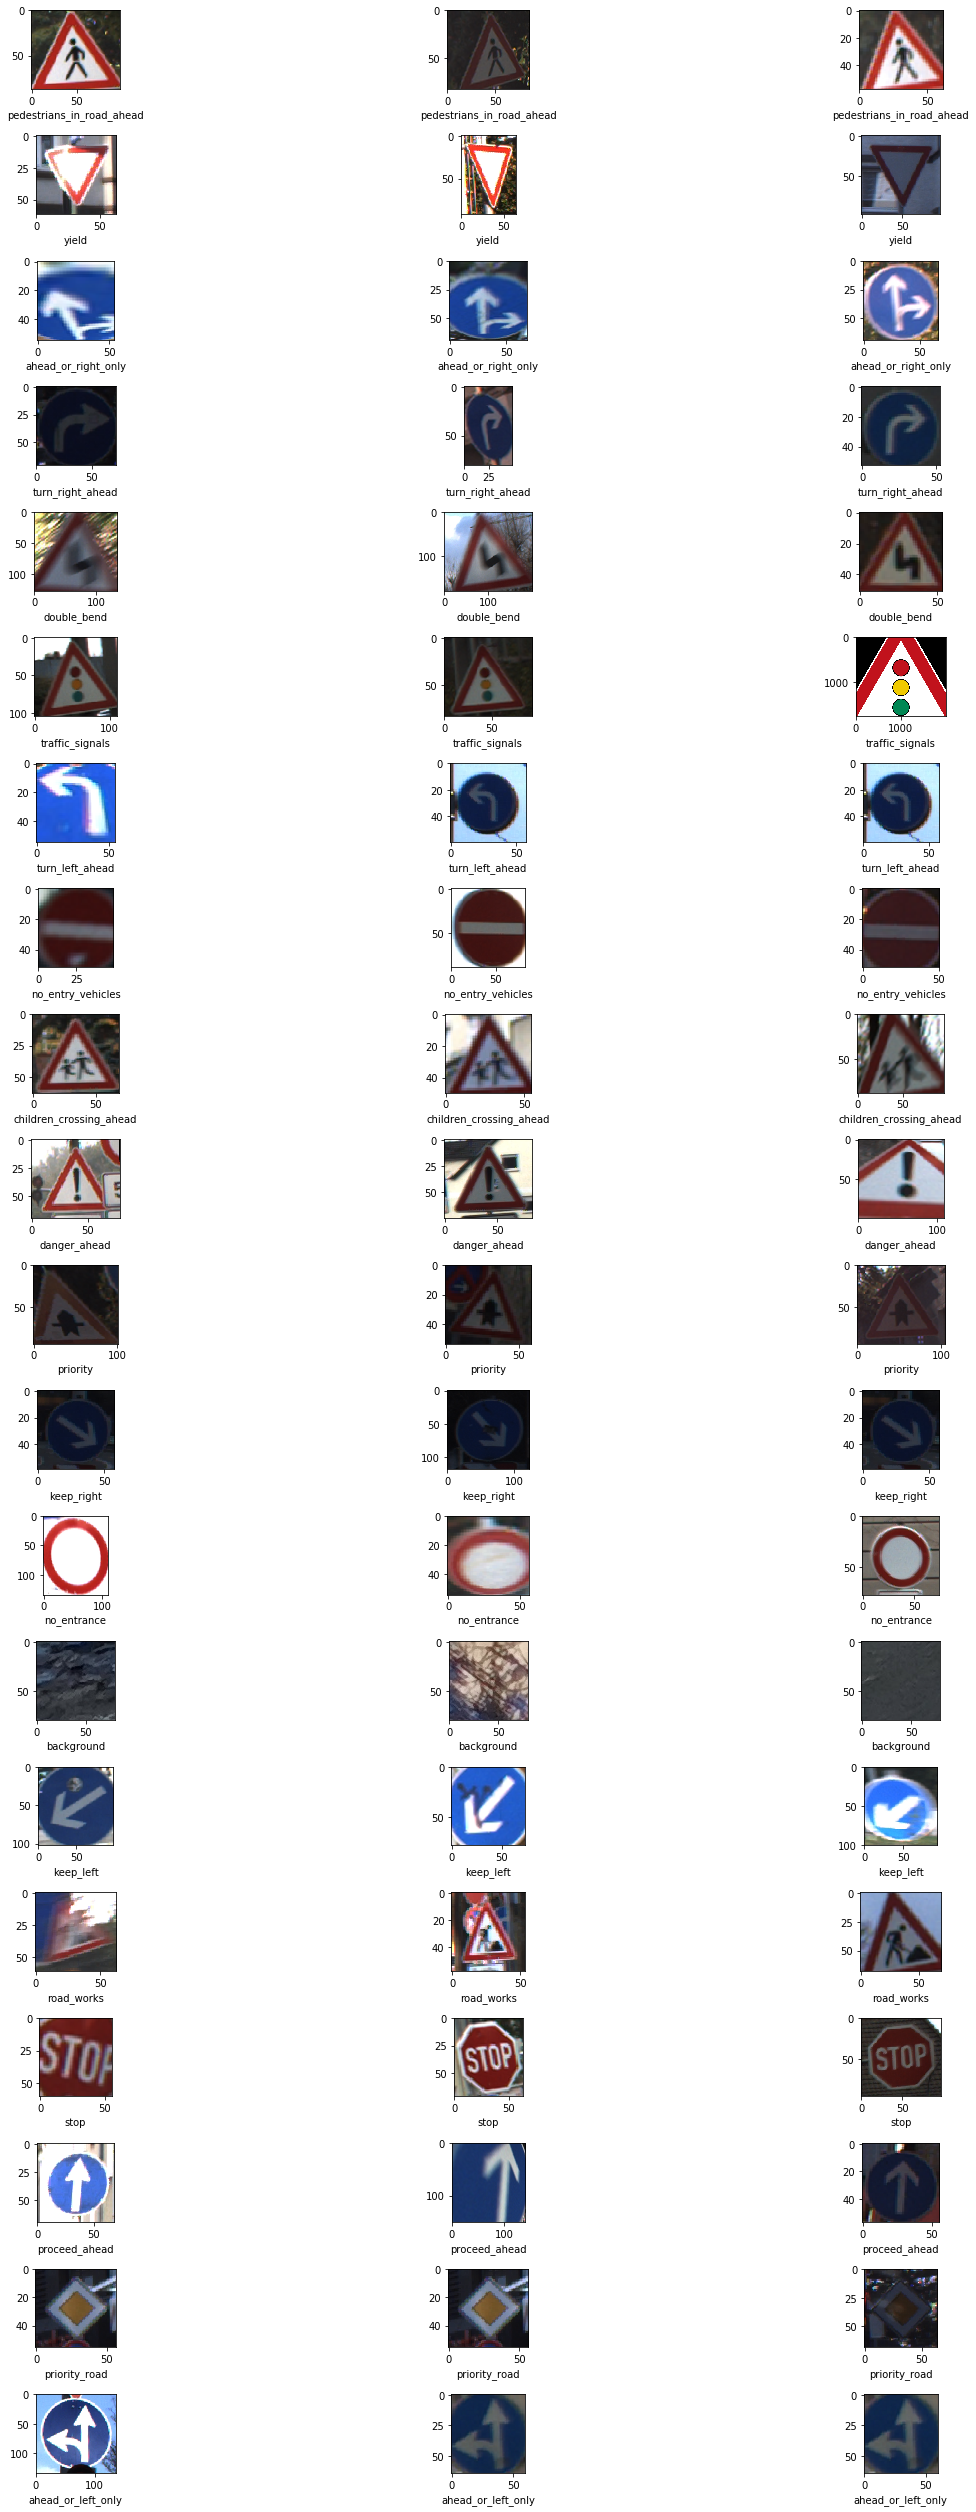

In [0]:
%matplotlib inline

fig = plt.figure(figsize=(20,35))
for sign_num, sign_type in enumerate(os.listdir("training_data/")):
    sign_path = os.path.join("training_data", sign_type)
    images = np.array(os.listdir(sign_path))
    
    selector = np.random.randint(0, len(sign_path), size=3)
    
    for j, img in enumerate(images[selector]):
        plt.subplot(20, 3, (sign_num * 3) + j + 1)
        plt.xlabel(sign_type)
        plt.imshow(cv.cvtColor(cv.imread(os.path.join(sign_path, img)), cv.COLOR_BGR2RGB))
        
fig.tight_layout()

## Data Augmentation

In order to prevent overfitting in our machine learning models, we make use of image augmentation in order to extend the training set size.
In a first step, we convert the images to a suitable file format for further processing and remove those images that are too small to be usable (below 50 x 50 px in size).

In [0]:
if not skip_preparation:
  for sign_num, sign_type in enumerate(os.listdir("training_data/")):
      sign_path = os.path.join("training_data", sign_type)
      images = os.listdir(sign_path)
      
      for image in images:
        try:
          img = cv.imread(os.path.join(sign_path, image))

          if img.shape[0] < 50 or img.shape[1] < 50:
              os.remove(os.path.join(sign_path, image))
          
          elif image.endswith("ppm"):
              cv.imwrite(os.path.join(sign_path, image.replace("ppm", "png")), img)
              os.remove(os.path.join(sign_path, image))
        except:
          pass

We can run an image augmentation library on the extracted data. Note that this takes a very long time.

In [0]:
if not skip_preparation:
  TARGET_NUMBER_OF_IMGS = 2000

  for sign_num, sign_type in enumerate(os.listdir("training_data/")):
      sign_path = os.path.join("training_data", sign_type)
      num_images = len(os.listdir(sign_path))

      p = Augmentor.Pipeline(sign_path)
      print("\n")

      p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
      p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
      p.skew(probability=0.3)

      if num_images <= TARGET_NUMBER_OF_IMGS:
        p.sample(TARGET_NUMBER_OF_IMGS - num_images)
      
      print("\n")

We can now move the generated images into the correct directories.

In [0]:
if not skip_preparation:
  for sign_num, sign_type in enumerate(os.listdir("training_data/")):
      sign_path = os.path.join("training_data", sign_type)
      output_path = os.path.join(sign_path, "output")

      for filename in os.listdir(output_path):
        os.rename(os.path.join(output_path, filename), os.path.join(sign_path, filename))

      os.rmdir(os.path.join(sign_path, "output"))

The data is processed by loading all images, resizing them to a dimension of 100 by 100 pixels and then storing the images in a NumPy array.

In [0]:
def process_image(fileName):
    img = cv.imread(fileName)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (100,100))
    return img

DATA_PATH = "training_data/"

X_train = []
y_train = []

num_samples = 0

signs = os.listdir(DATA_PATH)

for sign in signs:
    current_samples = num_samples
    
    sign_path = os.path.join(DATA_PATH, sign)
    
    for file in os.listdir(sign_path):
        if not (file.endswith(".ppm") or file.endswith(".png")):
            continue

        if num_samples - current_samples > 2000:
          continue
        
        img = process_image(os.path.join(sign_path, file))
        
        X_train.append(img)
        y_train.append(signs.index(sign))
        num_samples += 1

    print(f"Read {num_samples - current_samples} samples for {sign}.")

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Number of Samples: {num_samples}")

Read 2000 samples for pedestrians_in_road_ahead.
Read 2000 samples for yield.
Read 2000 samples for ahead_or_right_only.
Read 2000 samples for turn_right_ahead.
Read 2000 samples for double_bend.
Read 2000 samples for traffic_signals.
Read 2000 samples for turn_left_ahead.
Read 2000 samples for no_entry_vehicles.
Read 2000 samples for children_crossing_ahead.
Read 2000 samples for danger_ahead.
Read 2000 samples for priority.
Read 2000 samples for keep_right.
Read 2000 samples for no_entrance.
Read 2001 samples for background.
Read 2000 samples for keep_left.
Read 2000 samples for road_works.
Read 2000 samples for stop.
Read 2000 samples for proceed_ahead.
Read 2000 samples for priority_road.
Read 2000 samples for ahead_or_left_only.
Number of Samples: 40001


The authors of the GTSRB dataset provide an additional test dataset to be used during the development of the model. We download the files (one zip file containing the images and another one containing the labels).

In [0]:
!wget -c https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -O test_data.zip
!wget -c https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -O test_data_annotation.zip

with zipfile.ZipFile("test_data.zip", "r") as zip_ref:
  zip_ref.extractall("test_data")

with zipfile.ZipFile("test_data_annotation.zip", "r") as zip_ref:
  zip_ref.extractall()

--2020-02-05 22:33:07--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘test_data.zip’

test_data.zip       100%[===================>]  84.86M  19.1MB/s    in 4.4s    

2020-02-05 22:33:12 (19.1 MB/s) - ‘test_data.zip’ saved [88978620/88978620]

--2020-02-05 22:33:13--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘test_data_annotation.zip’

test_data_annotatio 100%[===================>]  97.29K   279KB/s    in 0.3s    

2020-02-05 22:33:14 (279 

The dataset labels are provided in a CSV file, which we read using pandas.

In [0]:
import pandas

test_files = pandas.read_csv("GT-final_test.csv", sep=';')
test_files.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11


We need a way to map the ClassId column in the CSV file back to the sign categories we are working with. We do this by creating a map that maps all valid ClassIds to the name of the sign, and maps all other ClassIds to -1 so that we can ignore them.

In [0]:
class_mapping = {
   0: -1,
   1: -1,
   2: -1,
   3: -1,
   4: -1,
   5: -1,
   6: -1,
   7: -1,
   8: -1,
   9: -1,
   10: -1,
   11: "priority",
   12: "priority_road",
   13: "yield",
   14: "stop",
   15: "no_entrance",
   16: -1,
   17: "no_entry_vehicles",
   18: "danger_ahead",
   19: -1,
   20: -1,
   21: "double_bend",
   22: -1,
   23: -1,
   24: -1,
   25: "road_works",
   26: "traffic_signals",
   27: "pedestrians_in_road_ahead",
   28: "children_crossing_ahead",
   29: -1,
   30: -1,
   31: -1,
   32: -1,
   33: "turn_right_ahead",
   34: "turn_left_ahead",
   35: "proceed_ahead",
   36: "ahead_or_right_only",
   37: "ahead_or_left_only",
   38: "keep_right",
   39: "keep_left",
   40: -1,
   41: -1,
   42: -1
}

In [0]:
DATA_PATH = "test_data/GTSRB/Final_Test/Images/"

X_test = []
y_test = []

for _, test_file in test_files.iterrows():
    imgpath = os.path.join(DATA_PATH, test_file["Filename"])

    classid = class_mapping[int(test_file["ClassId"])]

    if classid == -1 or test_file["Width"] <= 50 or test_file["Height"] <= 50:
      continue
    
    img = process_image(imgpath)
    
    X_test.append(img)
    y_test.append(signs.index(classid))

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(2190, 100, 100, 3)
(2190,)


This yields the following distribution for the training and test sets:

<BarContainer object of 20 artists>

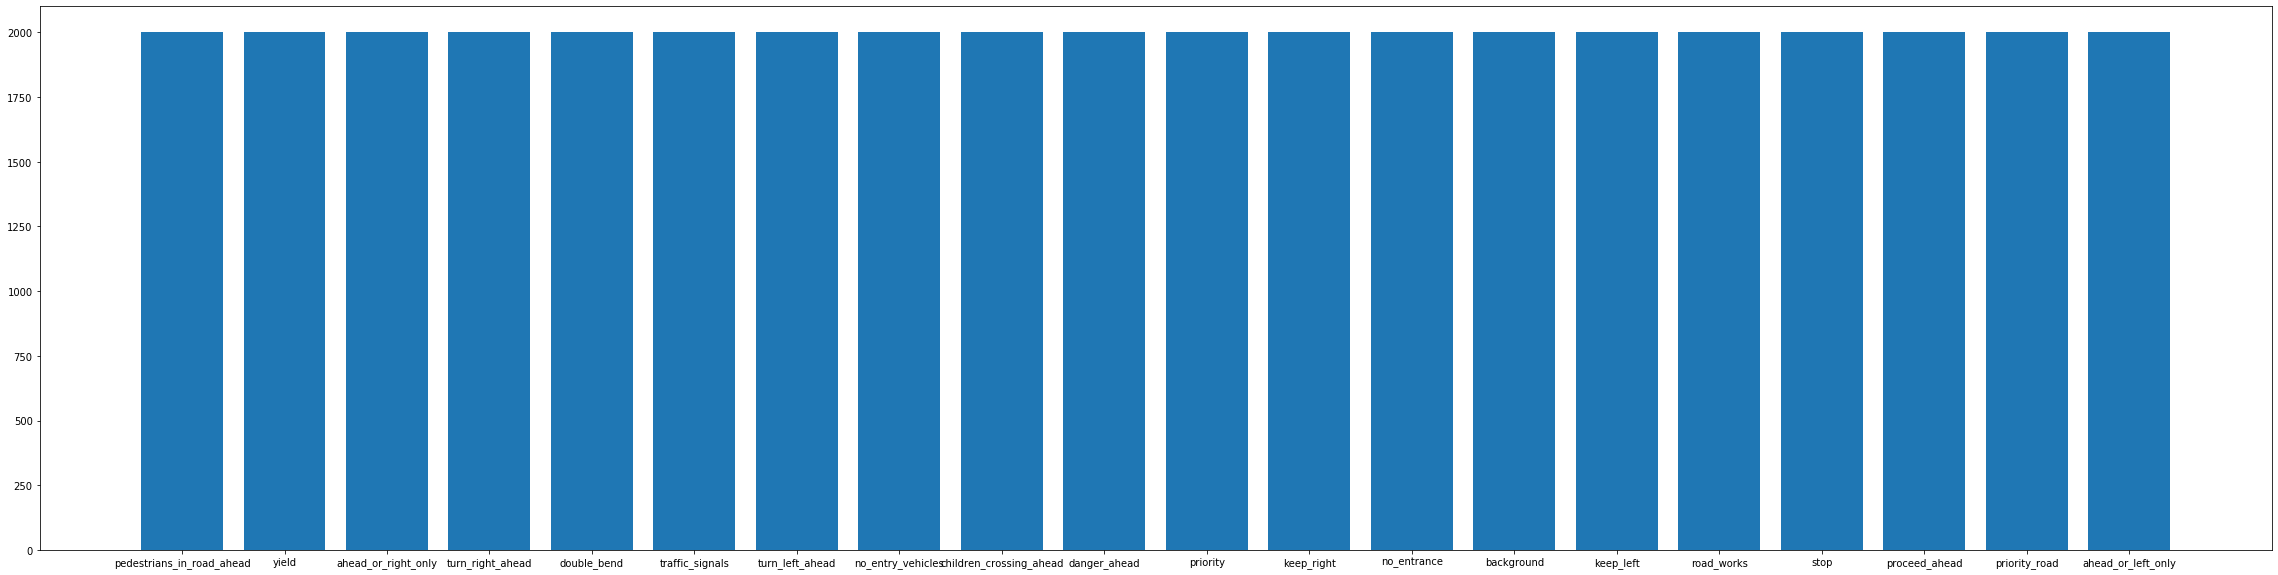

In [0]:
plt.figure(figsize=(40,10))
plt.bar(signs, [len(y_train[y_train == i]) for i in range(0, len(signs))])

<BarContainer object of 20 artists>

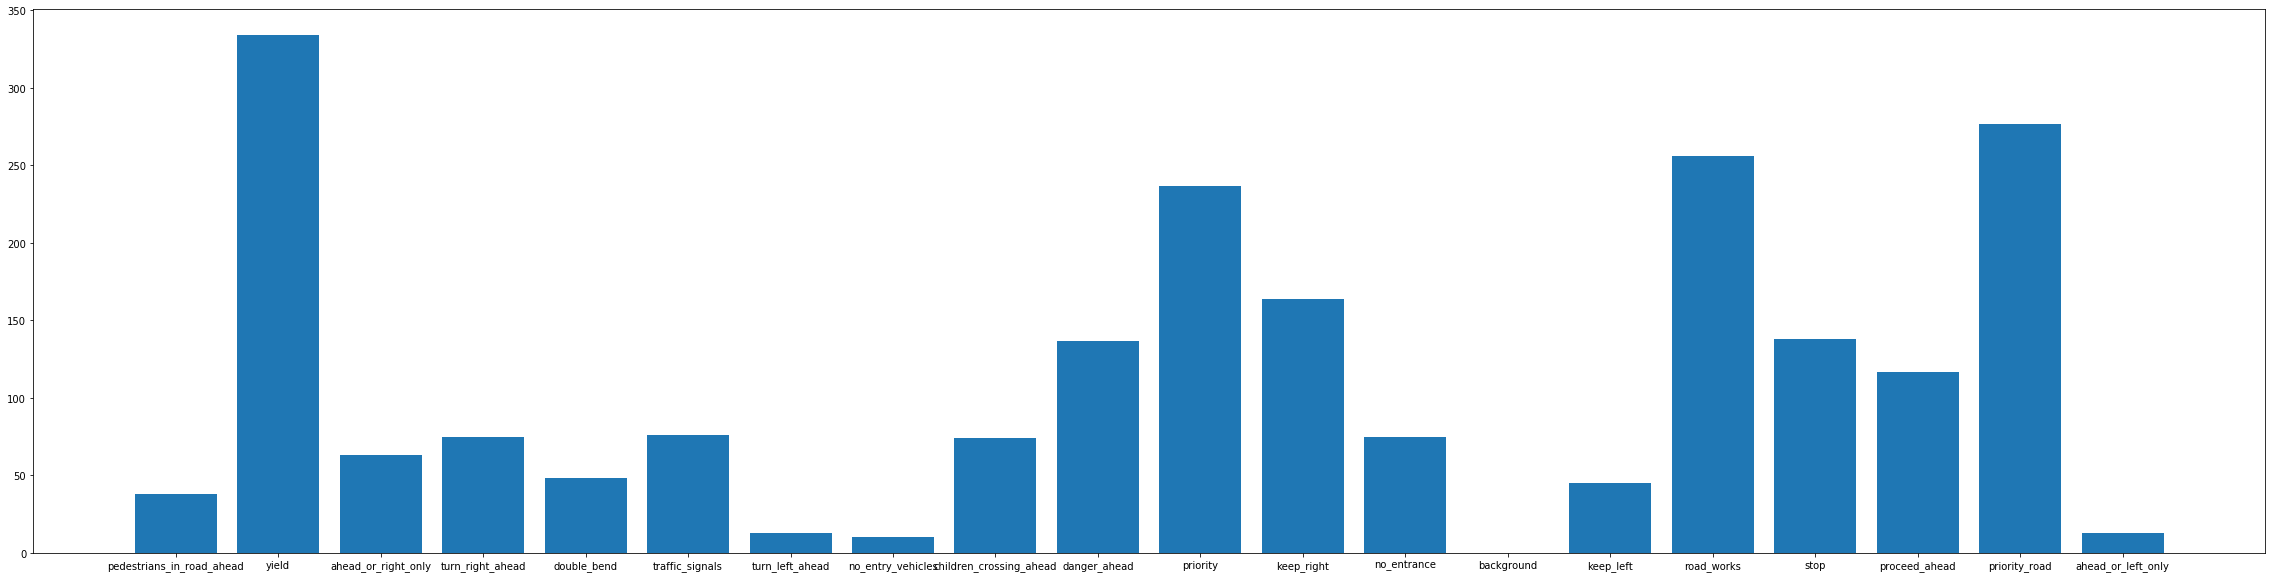

In [0]:
plt.figure(figsize=(40,10))
plt.bar(signs, [len(y_test[y_test == i]) for i in range(0, len(signs))])

As a final validation set we use the test data that was used to evaluate contributions to the IJCNN 2011 competition.

In [0]:
!wget -c https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip -O test_data_final.zip

!rm -r test_data_final
with zipfile.ZipFile("test_data_final.zip", "r") as zip_ref:
  zip_ref.extractall("test_data_final")

--2020-02-05 22:33:23--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88234254 (84M) [application/zip]
Saving to: ‘test_data_final.zip’

test_data_final.zip 100%[===================>]  84.15M  20.1MB/s    in 4.2s    

2020-02-05 22:33:28 (20.1 MB/s) - ‘test_data_final.zip’ saved [88234254/88234254]

rm: cannot remove 'test_data_final': No such file or directory


In [0]:
!rm -r test_data_final/GTSRB/Online-Test-sort/00000
!rm -r test_data_final/GTSRB/Online-Test-sort/00001
!rm -r test_data_final/GTSRB/Online-Test-sort/00002
!rm -r test_data_final/GTSRB/Online-Test-sort/00003
!rm -r test_data_final/GTSRB/Online-Test-sort/00004
!rm -r test_data_final/GTSRB/Online-Test-sort/00005
!rm -r test_data_final/GTSRB/Online-Test-sort/00006
!rm -r test_data_final/GTSRB/Online-Test-sort/00007
!rm -r test_data_final/GTSRB/Online-Test-sort/00008
!rm -r test_data_final/GTSRB/Online-Test-sort/00009
!rm -r test_data_final/GTSRB/Online-Test-sort/00010
!mv test_data_final/GTSRB/Online-Test-sort/00011 test_data_final/GTSRB/Online-Test-sort/priority
!mv test_data_final/GTSRB/Online-Test-sort/00012 test_data_final/GTSRB/Online-Test-sort/priority_road
!mv test_data_final/GTSRB/Online-Test-sort/00013 test_data_final/GTSRB/Online-Test-sort/yield
!mv test_data_final/GTSRB/Online-Test-sort/00014 test_data_final/GTSRB/Online-Test-sort/stop
!mv test_data_final/GTSRB/Online-Test-sort/00015 test_data_final/GTSRB/Online-Test-sort/no_entrance
!rm -r test_data_final/GTSRB/Online-Test-sort/00016
!mv test_data_final/GTSRB/Online-Test-sort/00017 test_data_final/GTSRB/Online-Test-sort/no_entry_vehicles
!mv test_data_final/GTSRB/Online-Test-sort/00018 test_data_final/GTSRB/Online-Test-sort/danger_ahead
!rm -r test_data_final/GTSRB/Online-Test-sort/00019
!rm -r test_data_final/GTSRB/Online-Test-sort/00020
!mv test_data_final/GTSRB/Online-Test-sort/00021 test_data_final/GTSRB/Online-Test-sort/double_bend
!rm -r test_data_final/GTSRB/Online-Test-sort/00022
!rm -r test_data_final/GTSRB/Online-Test-sort/00023
!rm -r test_data_final/GTSRB/Online-Test-sort/00024
!mv test_data_final/GTSRB/Online-Test-sort/00025 test_data_final/GTSRB/Online-Test-sort/road_works
!mv test_data_final/GTSRB/Online-Test-sort/00026 test_data_final/GTSRB/Online-Test-sort/traffic_signals
!mv test_data_final/GTSRB/Online-Test-sort/00027 test_data_final/GTSRB/Online-Test-sort/pedestrians_in_road_ahead
!mv test_data_final/GTSRB/Online-Test-sort/00028 test_data_final/GTSRB/Online-Test-sort/children_crossing_ahead
!rm -r test_data_final/GTSRB/Online-Test-sort/00029
!rm -r test_data_final/GTSRB/Online-Test-sort/00030
!rm -r test_data_final/GTSRB/Online-Test-sort/00031
!rm -r test_data_final/GTSRB/Online-Test-sort/00032
!mv test_data_final/GTSRB/Online-Test-sort/00033 test_data_final/GTSRB/Online-Test-sort/turn_right_ahead
!mv test_data_final/GTSRB/Online-Test-sort/00034 test_data_final/GTSRB/Online-Test-sort/turn_left_ahead
!mv test_data_final/GTSRB/Online-Test-sort/00035 test_data_final/GTSRB/Online-Test-sort/proceed_ahead
!mv test_data_final/GTSRB/Online-Test-sort/00036 test_data_final/GTSRB/Online-Test-sort/ahead_or_right_only
!mv test_data_final/GTSRB/Online-Test-sort/00037 test_data_final/GTSRB/Online-Test-sort/ahead_or_left_only
!mv test_data_final/GTSRB/Online-Test-sort/00038 test_data_final/GTSRB/Online-Test-sort/keep_right
!mv test_data_final/GTSRB/Online-Test-sort/00039 test_data_final/GTSRB/Online-Test-sort/keep_left
!rm -r test_data_final/GTSRB/Online-Test-sort/00040
!rm -r test_data_final/GTSRB/Online-Test-sort/00041
!rm -r test_data_final/GTSRB/Online-Test-sort/00042
!rm -r test_data_final/GTSRB/Online-Test-sort/Images
!rm -r test_data_final/GTSRB/Online-Test-sort/Readme.txt
!rm $(find test_data_final/GTSRB/Online-Test-sort/ -iname '*.csv')

In [0]:
DATA_PATH = "test_data_final/GTSRB/Online-Test-sort/"

X_validation = []
y_validation = []

validation_images = os.listdir(DATA_PATH)

for vimgs in validation_images:
    vimgs_path = os.path.join(DATA_PATH, vimgs)
    
    for file in os.listdir(vimgs_path):
        if not (file.endswith(".ppm") or file.endswith(".png")):
            continue
        
        shape = cv.imread(os.path.join(vimgs_path, file)).shape

        if shape[0] < 50 or shape[1] < 50:
          continue

        img = process_image(os.path.join(vimgs_path, file))
        
        X_validation.append(img)
        y_validation.append(signs.index(vimgs))

X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

print(X_validation.shape)
print(y_validation.shape)

(2245, 100, 100, 3)
(2245,)


We now have a training set used to train our models and two test sets used to evaluate their performance.

## Extracting image features and learning using a support vector machine

Our first approach to classifiying the traffic sign images, is using a support vector machine [0] classifier. In order to do that, we first compute a feature vector for each image by computing Histogram of Oriented Gradients (HOG) [1] features for each image.

[0] James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, eds. An Introduction to Statistical Learning: With Applications in R. Springer Texts in Statistics 103. New York: Springer, 2013.

[1] https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

In [0]:
import skimage.feature

X_train_hog = np.array([skimage.feature.hog(img) for img in X_train])
X_test_hog = np.array([skimage.feature.hog(img) for img in X_test])

After the conversion the training set now consists of *n* feature vectors, each with a size of 5184 predictors:

In [0]:
X_train_hog.shape

(40001, 8100)

We now have converted from the original high-dimensional space of dimension `19200 (= 80 * 80 * 3)` to a 5184-dimensional space, which is much more anemable to analysis by a statistical learning algorithm.

We can now use the `SGDClassifier` provided by scikit-learn, which implements a support vector machine trained using stochastic gradient descent (SGD).

In [0]:
from sklearn import linear_model

clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3, n_jobs=-1)

We can now fit the classifier to the training set of HOG feature vectors.

In [0]:
clf.fit(X_train_hog, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

We can now compute the training and test accuracy of our model:

In [0]:
print(f"Training accuracy: {clf.score(X_train_hog, y_train)}")
print(f"Test accuracy: {clf.score(X_test_hog, y_test)}")

Training accuracy: 0.9887252818679533
Test accuracy: 0.9575342465753425


Although this model provides adequate accuracy, it suffers from poor runtime performance due to the expensive computation of the HOG feature vectors. We have therefore focused on an alternative approach using a convolutional neural network (CNN) described below.

## Deep Learning

In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

tensorflow.get_logger().setLevel('ERROR')

#tensorflow.enable_eager_execution()

The model we designed is roughly guided by the VGG16 architecture [1] and the description of CNNs for image recognition given in the book by Chollet [2].
As such, it consists of two main components: A feature extractor build using convolutional layers and a classifier using fully-connected (i.e. dense) layers.
The feature extractor is build using 3 blocks of convolutional layers followed by Dropout for regularization and max pooling to reduce the input dimensions.
The classification happens at the last stage of the network, where the fully-connected "head" classifies the result into the traffic sign classes using a fully-connected layer with a softmax activation.

[1] Simonyan, Karen and Andrew Zisserman. “Very Deep Convolutional Networks for Large-Scale Image Recognition.” CoRR abs/1409.1556 (2014)

[2] Chollet, François. “Deep Learning with Python.” (2017)

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(20, activation='softmax'))

This is what our models looks like, including the number of parameters and the output shapes of the individual layers.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       7

We also make use of label smoothing [1], which is provided out of the box by Keras, to help prevent overfitting.

[1] He, Tong et al. “Bag of Tricks for Image Classification with Convolutional Neural Networks.” 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) (2018): 558-567.

In [0]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.2), 
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
X_train_reshaped = (X_train.astype('float32') / 255.0)
X_test_reshaped = X_test.astype('float32') / 255.0

We train our model using 30 epochs and include the test data as `validation_data` so that we can see the test set performance during the training process.

In [0]:
history = model.fit(X_train_reshaped, to_categorical(y_train), 
                    validation_data=(X_test_reshaped, to_categorical(y_test)), 
                    epochs=30)

Train on 40001 samples, validate on 2190 samples
Epoch 1/30
40001/40001 [==============================] - 26s 645us/sample - loss: 1.5680 - acc: 0.8354 - val_loss: 2.4635 - val_acc: 0.9265
Epoch 2/30
40001/40001 [==============================] - 19s 483us/sample - loss: 1.3142 - acc: 0.9464 - val_loss: 2.3046 - val_acc: 0.9516
Epoch 3/30
40001/40001 [==============================] - 19s 485us/sample - loss: 1.2896 - acc: 0.9594 - val_loss: 2.3953 - val_acc: 0.9443
Epoch 4/30
40001/40001 [==============================] - 19s 483us/sample - loss: 1.2788 - acc: 0.9649 - val_loss: 3.1134 - val_acc: 0.9452
Epoch 5/30
40001/40001 [==============================] - 19s 484us/sample - loss: 1.2761 - acc: 0.9667 - val_loss: 2.4887 - val_acc: 0.9411
Epoch 6/30
40001/40001 [==============================] - 19s 485us/sample - loss: 1.2712 - acc: 0.9704 - val_loss: 2.9013 - val_acc: 0.9338
Epoch 7/30
40001/40001 [==============================] - 19s 484us/sample - loss: 1.2706 - acc: 0.9702 -

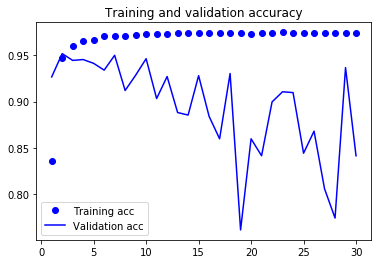

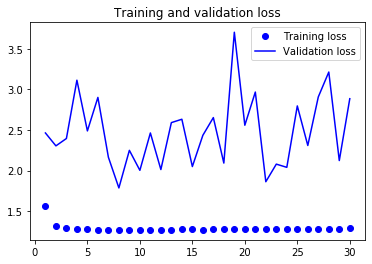

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.evaluate(X_test_reshaped, to_categorical(y_test))

2190/2190 [==============================] - 0s 173us/sample - loss: 2.8854 - acc: 0.8416


[2.8854149237070996, 0.8415525]

In addition to the raw accuracy, we can take a look at the confusion matrix to see if and where our model makes classification errors.

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, [np.argmax(p) for p in model.predict((X_test.astype('float32') / 255.0))])

print(np.array_str(cm, max_line_width=120))

[[ 38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 29 288   0   0   1  14   1   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0  63   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  72   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  47   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58  16   0   0   1   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  10   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  65   0   8   0   0   0   0   1   0   0   0   0]
 [  0   0   0   3   0   4  17   0   3 108   0   0   0   0   0   0   2   0   0   0]
 [  4   0   1   0   0   0   0   0   1   0 231   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0   0  34   0   0   2   0  13 109   0   0   0   0   0   0   0   0]
 [  

## Transfer Learning

As described in the previous section, using a CNN trained from scratch we are able to achieve an accuracy of about 92% on the test set. As a second approach we tried to improve upon that by using transfer learning. As a base architecture we use the VGG16 network, which comes prepackaged with Keras.

The model was trained on the ImageNet dataset and can be loaded (as we do here)
without the fully-connected classifier layers so that we can train our own classifier by using the VGG16 base network as a feature extractor and classifying the features using a fully-connected classifier on top.

In [0]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(100, 100, 3))

58892288/58889256 [==============================] - 1s 0us/step


We use the existing model as a feature extractor and add our dense layers on top to do the classification.

In [0]:
vgg_base.trainable = True

for layer in vgg_base.layers:
  layer.trainable = False

vgg_base.get_layer(name="block5_conv1").trainable = True
vgg_base.get_layer(name="block5_conv2").trainable = True
vgg_base.get_layer(name="block5_conv3").trainable = True

transfer_model = models.Sequential()

transfer_model.add(vgg_base)

transfer_model.add(layers.Dropout(0.5))
transfer_model.add(layers.Flatten()) 
transfer_model.add(layers.Dense(2048, activation='relu'))
transfer_model.add(layers.Dropout(0.5))
transfer_model.add(layers.Dense(20, activation='softmax'))

In [0]:
transfer_model.compile(loss=CategoricalCrossentropy(label_smoothing=0.2), 
                       optimizer=optimizers.RMSprop(lr=1e-5),
                       metrics=['acc'])

In [0]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              9439232   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                40980     
Total params: 24,194,900
Trainable params: 16,559,636
Non-trainable params: 7,635,264
__________________________________

As the summary shows, the VGG network is almost twice as large as our own CNN. Since we have frozen almost all of the base networks layers (i.e. they won't be updated during training) we only have to adjust the rougly 7 million parameters in the remaining layers.

In [0]:
history = transfer_model.fit(X_train_reshaped, to_categorical(y_train), 
                            validation_data=(X_test_reshaped, to_categorical(y_test)), 
                            epochs=10)

Train on 40001 samples, validate on 2190 samples
Epoch 1/10
40001/40001 [==============================] - 39s 977us/sample - loss: 1.7486 - acc: 0.7276 - val_loss: 1.3225 - val_acc: 0.9205
Epoch 2/10
40001/40001 [==============================] - 38s 955us/sample - loss: 1.2232 - acc: 0.9703 - val_loss: 1.2462 - val_acc: 0.9411
Epoch 3/10
40001/40001 [==============================] - 38s 953us/sample - loss: 1.1579 - acc: 0.9883 - val_loss: 1.2144 - val_acc: 0.9479
Epoch 4/10
40001/40001 [==============================] - 38s 955us/sample - loss: 1.1315 - acc: 0.9933 - val_loss: 1.2162 - val_acc: 0.9511
Epoch 5/10
40001/40001 [==============================] - 38s 954us/sample - loss: 1.1156 - acc: 0.9957 - val_loss: 1.2241 - val_acc: 0.9479
Epoch 6/10
40001/40001 [==============================] - 38s 955us/sample - loss: 1.1043 - acc: 0.9972 - val_loss: 1.2239 - val_acc: 0.9575
Epoch 7/10
40001/40001 [==============================] - 38s 953us/sample - loss: 1.0971 - acc: 0.9979 -

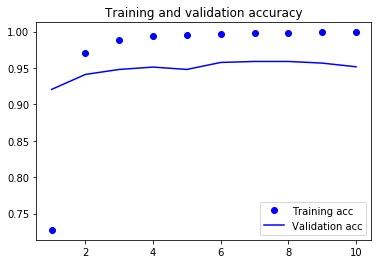

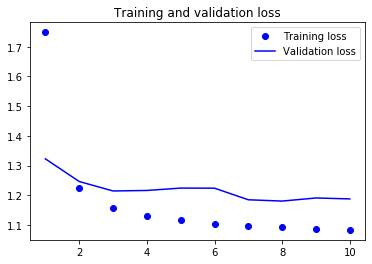

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

Using this model we are now able to achieve 96% accuracy on the test set provided by the GTSRB authors, thus improving on the previous model we trained from scratch.

## Import and analyse a Picture

This is our final implementation for the analysis of an image. 

First of all, we need the desired output characters to present the result of the analysis with a recommendation for action.

In [0]:
!wget -q 'https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-traffic-signs/master/Pres_5/img/stop.jpg'  -O stop.jpg
!wget -q 'https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-traffic-signs/master/Pres_5/img/thump_up_green.jpg' -O thump_up_green.jpg
!wget -q 'https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-traffic-signs/master/Pres_5/img/thump_up_yellow.jpg' -O thump_up_yellow.jpg

In [0]:
start_w = 0
start_h = 0
end_w = 0
end_h = 0
def get_range_contours(x, y, w, h, image_h, image_w):
  mid_w = int(x + w/2)
  mid_h = int(y + h/2)
  if w < h:
    h = int((h + (h * 0.5))/2)
    w = h
  elif w > h:
    w = int((w + (w * 0.5))/2)
    h = w
  start_h = np.maximum(mid_h - h, 0)
  end_h = np.minimum(mid_h + h, image_h-1)
  start_w = np.maximum(mid_w - w, 0)
  end_w = np.minimum(mid_w + w, image_w-1)
  return start_h,end_h, start_w, end_w

The following method examines the created mask for contours. Only contours with a certain size, depending on the overall size of the image, are considered. If an outline is detected, it is cut out and labelled by our Machine Learning Algorythm. Based on the suspected traffic sign, an index for the respective recommended action is stored. In the end, it shows the contour and calls up the method for pointing out the recommended action with the stored index.

In [0]:
def get_contours(image,mask):
  (cnts, _) = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  idx = 0
  contour_images = []
  contour_titles = []
  bimage = image.copy()
  image_size = image.shape[0] * image.shape[1] * 0.001
  result_sign = 0
  for c in cnts:
    area = cv.contourArea(c) 
    # Shortlisting the regions based on there area. 
    if area > image_size:
      x,y,w,h = cv.boundingRect(c)
      if w>50 and h>50:
        idx+=1
        (sh,eh,sw,ew) = get_range_contours(x,y,w,h,image.shape[0],image.shape[1])
        new_img = image[sh:eh,sw:ew]
        cv.imwrite(str(idx) + '.png', new_img)
        sign_image = cv.resize(new_img, (100, 100))
        sign_image = (sign_image.astype('float32') / 255).reshape(-1, 80 * 80 * 3)
        contour_images.append(new_img)
        pred = transfer_model.predict([sign_image])
        label = signs[np.argmax(pred)]
        result_sign = check_result(np.argmax(pred), result_sign)
        contour_titles.append(label)
  
        cv.putText(bimage, label, (x, y), cv.FONT_HERSHEY_COMPLEX, 1.5, (255, 0, 0), 2 , cv.LINE_AA)
        bimage = cv.rectangle(bimage, (sw, sh), (ew, eh), (255,0,0), 2)

  show_images(contour_images,1,contour_titles) 
  show_result_sign(result_sign)
  #plt.figure(figsize=(20,20))
  #plt.imshow(bimage)

In [0]:
def check_result(sign_number, previous):
  if previous == 1 or (sign_number == 1 or sign_number == 3 or sign_number == 6 or sign_number == 8):
    return 1
  elif (sign_number == 13 or sign_number == 16):
    return 2
  else:
    return previous

Depending on the index of the recommended action, the respective image is loaded and output for visualization.

In [0]:
def show_result_sign(sign_num):
  plt.figure()
  if sign_num == 1:
    imgre = cv.imread("stop.jpg")
  elif sign_num == 2:
    imgre = cv.imread("thump_up_green.jpg")
  else:
    imgre = cv.imread("thump_up_yellow.jpg")
  imgre=cv.cvtColor(imgre, cv.COLOR_BGR2RGB)
  show_images([imgre],1,["result"])

# 6. Conclusion

## Execution 

The first cell allows the user to upload an image for analysis. The second analyzes the image using the HSV color space used at the beginning. (Only the color red is filtered)
The third method analyses the image by filtering for red, blue and yellow. Both methods give a visual recommendation for action as feedback. We have thus achieved our goal of recognizing traffic signs in good conditions in the scene and giving a child-oriented recommendation for action.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving IMG_20191021_170119.jpg to IMG_20191021_170119.jpg
Saving SelBild_1.jpg to SelBild_1.jpg
Saving SelBild_2.jpg to SelBild_2.jpg


<Figure size 0x0 with 0 Axes>

<Figure size 432x288 with 0 Axes>

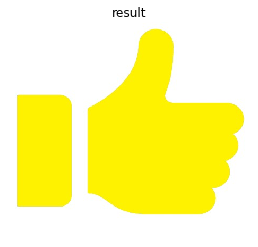

ValueError: ignored

In [0]:
for fn in uploaded.keys():
  image_return = image_transformation_hsv(fn)
  get_contours(image_return[0], image_return[2])

In [0]:
for fn in uploaded.keys():
  load_image(fn)
  image_return = image_transformation_hls(fn)
  get_contours(image_return[0], image_return[2])

# 7. Outlook

The next steps for this projects are a mobile application and better detection of signs. A mobile application with detection is in process. 
Another idea is a object detection. This target has exceeded the scoop of this course. 
The last step in the future of this project is a bigger dataset of different signs.  

## Running on mobile devices

In [0]:
import tensorflow
transfer_model.save("model.savedmodel", save_format=tensorflow.keras.experimental.export_saved_model)
converter = tensorflow.lite.TFLiteConverter.from_keras_model_file("model.h5")
tflite_model = converter.convert()

In [0]:
f = open("traffic_sign_model.tflite", "w+b")
f.write(tflite_model)
f.close()

In [0]:
interpreter = tensorflow.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
interpreter.set_tensor(input_details[0]['index'], [X_train[1300].astype('float32') / 255.0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
interpreter.get_tensor(output_details[0]['index'])